# Predicting Remaining Useful Life with Manual Feature Engineering

In this notebook, we will work with NASA provided data to accomplish a critical real-world task: predict the remaining useful life of an engine. Our first attempt will be to tackle this problem by hand, building features based on aggregations, domain knowledge (if applicable), and time-series based methods. The original data can be downloaded [here.](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan)

## Roadmap 

Following will be our approach to this problem:

1. Specify the prediction problem
    * For each engine, define the cutoff point and label
2. Subset data to before cutoff point for each engine
3. Establish a baseline performance measure
4. Perform basic aggregations for each engine to develop features
    * Use feature selection to reduce the number of features
5. Evaluate performance of features 
    * In cross validation on the training data 
    * On the testing data
6. Try more sophisticated feature engineering
    * Time-series analysis
    * KMeans clustering
7. Evaluate performance of new features
    * Use feature selection
8. Perform random search to tune the random forest model

This problem is a good basic introduction to time-series prediction. Even though we have all the data for all the engines, when we make features, we have to limit ourselves to data from before the cutoff time in order to ensure our model trains on valid data.

In [1]:
import pandas as pd
import numpy as np

from utils import plot_feature_importances, feature_selection

First we need to read in the data and set the correct columns headers as specified in the data documentation.

In [2]:
operational_settings = ['operational_setting_{}'.format(i + 1) for i in range (3)]
sensor_columns = ['sensor_measurement_{}'.format(i + 1) for i in range(26)]
cols = ['engine_no', 'time_in_cycles'] + operational_settings + sensor_columns
data = pd.read_csv('../input/train_FD002.txt', sep=' ', header=-1, names=cols)
data.head()

,engine_no,time_in_cycles,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,sensor_measurement_22,sensor_measurement_23,sensor_measurement_24,sensor_measurement_25,sensor_measurement_26
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,334,2223,100.00,14.73,8.8071,NaN,NaN,NaN,NaN,NaN
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,330,2212,100.00,10.41,6.2665,NaN,NaN,NaN,NaN,NaN
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,309,1915,84.93,14.08,8.6723,NaN,NaN,NaN,NaN,NaN
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,329,2212,100.00,10.59,6.4701,NaN,NaN,NaN,NaN,NaN
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,309,1915,84.93,14.13,8.5286,NaN,NaN,NaN,NaN,NaN


There are 3 operational settings and 26 sensor measurements. Ahead of time, we have no idea which of these are relevant!

# Prediction Problem

The training data initially has no prediction problem: we are given the entire operational history of the engine with the final entry representing the last successful measurement before failure. Therefore, we have to come up with our own prediction problem which we do as follows:

1. Select an arbitrary starting date: January 1, 2010
2. Create a time column using the `time_in_cycles` and the knowledge that one cycle takes 10 minutes
3. For each engine, select a random time to use as the cutoff point
4. Find the number of cycles between the cutoff point and the end of life of the engine, this becomes the label
5. Subset the data for each engine to only the times before the prediction point. 

At the end of this process, we will have a labeled training set where each row is one engine and the label is the number of cycles to failure from that point (the `prediction_point` also called the `cutoff_time`) in time. We can then use the past operating data from before the prediction point and the labels to train a machine learning model. 

In [3]:
# Pick a starting date (this can be arbitrary)
starting_date = pd.Timestamp(2010, 1, 1)

# Create a time column using the time in cycles * 10 minutes per cycle
data['time'] = [starting_date + pd.Timedelta(x * 10, 'm') for x in data['time_in_cycles']]

data[['engine_no', 'time_in_cycles', 'time']].head()

,engine_no,time_in_cycles,time
0,1,1,2010-01-01 00:10:00
1,1,2,2010-01-01 00:20:00
2,1,3,2010-01-01 00:30:00
3,1,4,2010-01-01 00:40:00
4,1,5,2010-01-01 00:50:00


Now, for each engine, we need to pick a random time to serve as the prediction point. We will impose the limits that we need to have at least 10 measurements before the prediction point.

In [4]:
np.random.seed(50)

# Dataframe to hold results
engines = pd.DataFrame(columns = ['engine_no', 'prediction_point', 'label'])
engine_list = data['engine_no'].unique()

# Iterate through each engine
for engine in engine_list:
    
    # Subset to the engine
    subset = data[data['engine_no'] == engine].copy().sort_values('time')
    
    measurements = subset.shape[0]
    
    # Select a random index for the prediction point
    random_index = np.random.randint(10, measurements - 1)
    
    # Record the predictino point and the label which is the remaining number of cycles
    prediction_point = subset.iloc[random_index, :].copy()['time']
    label = measurements - random_index
    
    # Record the measurements
    engines = engines.append(pd.DataFrame({'engine_no': engine, 'prediction_point': prediction_point, 
                                           'label': label}, index = [0]), 
                             ignore_index = True, sort = True)

In [5]:
# Save prediction problem 
engines.to_csv('../input/engines_4.csv', index = False)
engines.head()

,engine_no,label,prediction_point
0,1,30,2010-01-01 20:00:00
1,2,127,2010-01-01 23:50:00
2,3,126,2010-01-01 13:30:00
3,4,155,2010-01-01 13:30:00
4,5,122,2010-01-01 05:30:00


# Limit Data to before prediction point

For each engine, we can only use data from before the `prediction_point` to predict when the engine will fail. We need to subset the `data` table for each engine until only times before the `prediction_point`. In Featuretools, the prediction point is called the `cutoff_time`.

In [6]:
legal_data = pd.DataFrame(columns = data.columns)

for i, engine in engines.iterrows():
    # Subset to times before the prediction point
    legal_data_subset = data[(data['time'] < engine['prediction_point']) & (data['engine_no'] == engine['engine_no'])].copy()
    
    legal_data = legal_data.append(legal_data_subset, ignore_index = True, sort = True)

In [7]:
train_obs = legal_data.copy()
train_obs.to_csv('../input/train_obs.csv', index = False)
train_obs.head()

,engine_no,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_10,sensor_measurement_11,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,...,sensor_measurement_26,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,sensor_measurement_6,sensor_measurement_7,sensor_measurement_8,sensor_measurement_9,time,time_in_cycles
0,1,34.9983,0.8400,100.0,449.44,1.02,42.02,183.06,2387.72,8048.56,...,NaN,1358.61,1137.23,5.48,8.00,194.64,2222.65,8341.91,2010-01-01 00:10:00,1
1,1,41.9982,0.8408,100.0,445.00,1.02,42.20,130.42,2387.66,8072.30,...,NaN,1353.22,1125.78,3.91,5.71,138.51,2211.57,8303.96,2010-01-01 00:20:00,2
2,1,24.9988,0.6218,60.0,462.54,0.94,36.69,164.22,2028.03,7864.87,...,NaN,1256.76,1047.45,7.05,9.02,175.71,1915.11,8001.42,2010-01-01 00:30:00,3
3,1,42.0077,0.8416,100.0,445.00,1.02,41.96,130.72,2387.61,8068.66,...,NaN,1354.03,1126.38,3.91,5.71,138.46,2211.58,8303.96,2010-01-01 00:40:00,4
4,1,25.0005,0.6203,60.0,462.54,0.94,36.89,164.31,2028.00,7861.23,...,NaN,1257.71,1047.93,7.05,9.03,175.05,1915.10,7993.23,2010-01-01 00:50:00,5


## Metric and Baseline 

Before we go any further, it's important to establish the metric we will use to judge how well our model does and a baseline measure of performance. For this regression problem, we'll use the [__Mean Absolute Percentage Error__ (MAPE)](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error),  a common metric that is easy to calculate and interpretable. This is the average of the absolute value of (prediction - true value) / true value) and is expressed as a percentage. 

For the naive baseline, we can use two methods:

1. Guess the average value of the label in the training data for all instances on the testing set. This will be called `average_guess`.
2. For each engine in the testing data, predict it has reached half its life at the end of the data and will continue to operate for however many cycles it has already operated. This will be called `half_life_guess`.

First we need to read in the testing data which is the same format as the training data.

In [8]:
test_obs = pd.read_csv('../input/test_FD002.txt', sep=' ', header=-1, names=cols)

# Pick a starting date (this can be arbitrary)
starting_date = pd.Timestamp(2010, 1, 1)

# Create a time column using the time in cycles * 10 minutes per cycle
test_obs['time'] = [starting_date + pd.Timedelta(x * 10, 'm') for x in test_obs['time_in_cycles']]

test_obs.to_csv('../input/test_obs.csv', index = False)
test_obs.head()

,engine_no,time_in_cycles,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,sensor_measurement_22,sensor_measurement_23,sensor_measurement_24,sensor_measurement_25,sensor_measurement_26,time
0,1,1,9.9987,0.2502,100.0,489.05,605.03,1497.17,1304.99,10.52,...,2319,100.00,28.42,17.1551,NaN,NaN,NaN,NaN,NaN,2010-01-01 00:10:00
1,1,2,20.0026,0.7000,100.0,491.19,607.82,1481.20,1246.11,9.35,...,2324,100.00,24.29,14.8039,NaN,NaN,NaN,NaN,NaN,2010-01-01 00:20:00
2,1,3,35.0045,0.8400,100.0,449.44,556.00,1359.08,1128.36,5.48,...,2223,100.00,14.98,8.9125,NaN,NaN,NaN,NaN,NaN,2010-01-01 00:30:00
3,1,4,42.0066,0.8410,100.0,445.00,550.17,1349.69,1127.89,3.91,...,2212,100.00,10.35,6.4181,NaN,NaN,NaN,NaN,NaN,2010-01-01 00:40:00
4,1,5,24.9985,0.6213,60.0,462.54,536.72,1253.18,1050.69,7.05,...,1915,84.93,14.31,8.5740,NaN,NaN,NaN,NaN,NaN,2010-01-01 00:50:00


In [9]:
# Half life guess
train_half_life_guess = train_obs.groupby('engine_no').apply(lambda x: 2 * x.shape[0])

# Dataframe with both baselines
train_baseline = pd.DataFrame({'engine_no': train_obs['engine_no'].unique(), 
                               'half_life_guess': train_half_life_guess.values,
                               'average_guess': engines['label'].mean()})

In [10]:
# Make two baseline guesses
test_half_life_guess = test_obs.groupby('engine_no').apply(lambda x: 2 * x.shape[0])
test_baseline = pd.DataFrame({'engine_no': test_obs['engine_no'].unique(), 
                              'half_life_guess': test_half_life_guess.values,
                               'average_guess': engines['label'].mean()})

The labels for the testing data are in a separate file that we can read in.

In [11]:
test_y = pd.read_csv('../input/RUL_FD002.txt', sep=' ', header=-1, names=['label'], index_col=False)

We'll write a basic function to calculate the mean absolute percentage error and then apply it to the two baselines.

In [12]:
def mape(y_true, pred):
    mape = 100 * np.mean(abs(y_true - pred) / y_true)
    
    return mape

In [13]:
print('The average_guess train MAPE is: {:.2f}.'.format(mape(engines['label'], train_baseline['average_guess'])))
print("The average_guess  test MAPE is: {:.2f}.".format(mape(test_y['label'], test_baseline['average_guess'])))

The average_guess train MAPE is: 158.89.
The average_guess  test MAPE is: 226.44.


In [14]:
print('The half_life train MAPE is: {:.2f}.'.format(mape(engines['label'], train_baseline['half_life_guess'])))
print('The half_life  test MAPE is: {:.2f}.'.format(mape(test_y['label'], test_baseline['half_life_guess'])))

The half_life train MAPE is: 614.89.
The half_life  test MAPE is: 926.51.


These baselines give us a target for our machine learning models. If our model cannot beat even a naive baseline, then maybe we want to rethink the machine learnign approach!

# Approach to Feature Engineering

The `train_obs` is now a child table of `engines` because for each unique engine (identified by the `engine_no`), there are multiple rows in the `train_obs`. Our final train dataframe will need to have one unique row for every engine, with the features in the columns, so feature engineering will involve aggregating the `train_obs` for every engine. The same operations that are done to `train_obs` will have to be applied to `test_obs` as well because we need to have the same columns in both the training and testing set.

In [15]:
train_obs = train_obs.drop(columns = 'time')
train_obs.shape 

(27403, 31)

## Aggregations

As a simple first step, we can perform numerical aggregations of every column in `train_obs` table. If we have no idea what the columns represent, this is a good place to start because it will provide a thorough summary of every column.

In [16]:
# First deal with some annoying type issues
train_obs['sensor_measurement_17'] = train_obs['sensor_measurement_17'].astype(np.float32)
train_obs['sensor_measurement_18'] = train_obs['sensor_measurement_18'].astype(np.float32)
train_obs['time_in_cycles'] = train_obs['time_in_cycles'].astype(np.int32)

# Aggregate each column
train_agg = train_obs.groupby('engine_no').agg(['min', 'max', 'mean', 'sum', 'std'])
train_agg.head()

operational_setting_1                                            \
                            min      max       mean        sum        std   
engine_no                                                                   
1                        0.0000  42.0077  25.414484  3024.3236  15.300117   
2                        0.0000  42.0076  23.734917  3370.3582  14.711035   
3                        0.0002  42.0073  25.365650  2029.2520  13.972098   
4                        0.0004  42.0075  23.640294  1891.2235  15.508015   
5                        0.0008  42.0071  21.721191   695.0781  14.481060   

          operational_setting_2                                       \
                            min     max      mean      sum       std   
engine_no                                                              
1                           0.0  0.8419  0.590210  70.2350  0.315502   
2                           0.0  0.8420  0.571921  81.2128  0.310070   
3                           0.0  0.8420  0.600951  48.0761  0.282966   
4                           0.0  0.8415  0.563961  45.1169  0.323623   
5                           0.0  0.8417  0.528438  16.9100  0.319769   

             ...     sensor_measurement_9                                    \
             ...                      min      max         mean         sum   
engine_no    ...                                                              
1            ...                  7993.23  9051.13  8475.882857  1008630.06   
2            ...                  8005.94  9074.03  8525.690704  1210648.08   
3            ...                  8007.77  9060.51  8496.240750   679699.26   
4            ...                  8004.46  9061.68  8562.626375   685010.11   
5            ...                  8009.47  9066.37  8548.107500   273539.44   

                      time_in_cycles                               
                  std            min  max  mean    sum        std  
engine_no                                                          
1          344.834682              1  119  60.0   7140  34.496377  
2          347.059747              1  142  71.5  10153  41.135953  
3          305.517658              1   80  40.5   3240  23.237900  
4          328.079571              1   80  40.5   3240  23.237900  
5          347.725391              1   32  16.5    528   9.380832  

[5 rows x 150 columns]

In order to better keep track of the columns, we can rename them using a for loop with the original column and then the statistic.

In [17]:
new_cols = []

# Iterate through the columns and create new names
for col in train_agg.columns.levels[0]:
    for stat in train_agg.columns.levels[1]:
        new_cols.append(f'{col}-{stat}')
        
train_agg.columns = new_cols
train_agg.head()

,operational_setting_1-min,operational_setting_1-max,operational_setting_1-mean,operational_setting_1-sum,operational_setting_1-std,operational_setting_2-min,operational_setting_2-max,operational_setting_2-mean,operational_setting_2-sum,operational_setting_2-std,...,sensor_measurement_9-min,sensor_measurement_9-max,sensor_measurement_9-mean,sensor_measurement_9-sum,sensor_measurement_9-std,time_in_cycles-min,time_in_cycles-max,time_in_cycles-mean,time_in_cycles-sum,time_in_cycles-std
engine_no,,,,,,,,,,,,,,,,,,,,,
1,0.0000,42.0077,25.414484,3024.3236,15.300117,0.0,0.8419,0.590210,70.2350,0.315502,...,7993.23,9051.13,8475.882857,1008630.06,344.834682,1,119,60.0,7140,34.496377
2,0.0000,42.0076,23.734917,3370.3582,14.711035,0.0,0.8420,0.571921,81.2128,0.310070,...,8005.94,9074.03,8525.690704,1210648.08,347.059747,1,142,71.5,10153,41.135953
3,0.0002,42.0073,25.365650,2029.2520,13.972098,0.0,0.8420,0.600951,48.0761,0.282966,...,8007.77,9060.51,8496.240750,679699.26,305.517658,1,80,40.5,3240,23.237900
4,0.0004,42.0075,23.640294,1891.2235,15.508015,0.0,0.8415,0.563961,45.1169,0.323623,...,8004.46,9061.68,8562.626375,685010.11,328.079571,1,80,40.5,3240,23.237900
5,0.0008,42.0071,21.721191,695.0781,14.481060,0.0,0.8417,0.528438,16.9100,0.319769,...,8009.47,9066.37,8548.107500,273539.44,347.725391,1,32,16.5,528,9.380832


That fairly simple operation gave us 150 features that we can use as a main training dataframe. 

### Assess Performance

Let's assess the performance of just these features in a model. We need to make sure to apply the same operations to the testing data.

In [18]:
# Apply same operations to testing data
test_agg = test_obs.groupby('engine_no').agg(['min', 'max', 'mean', 'sum', 'std'])

new_cols = []

for col in test_agg.columns.levels[0]:
    for stat in test_agg.columns.levels[1]:
        new_cols.append(f'{col}-{stat}')
        
test_agg.columns = new_cols
test_agg.head()

,time_in_cycles-min,time_in_cycles-max,time_in_cycles-mean,time_in_cycles-sum,time_in_cycles-std,operational_setting_1-min,operational_setting_1-max,operational_setting_1-mean,operational_setting_1-sum,operational_setting_1-std,...,sensor_measurement_25-min,sensor_measurement_25-max,sensor_measurement_25-mean,sensor_measurement_25-sum,sensor_measurement_25-std,sensor_measurement_26-min,sensor_measurement_26-max,sensor_measurement_26-mean,sensor_measurement_26-sum,sensor_measurement_26-std
engine_no,,,,,,,,,,,,,,,,,,,,,
1,1,258,129.5,33411,74.622383,0.0002,42.0078,24.157602,6232.6614,14.625359,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN
2,1,55,28.0,1540,16.020820,0.0005,42.0079,26.512127,1458.1670,15.193411,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN
3,1,165,83.0,13695,47.775517,0.0001,42.0078,22.663222,3739.4316,15.144796,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN
4,1,86,43.5,3741,24.969982,0.0002,42.0078,24.061074,2069.2524,14.675946,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN
5,1,148,74.5,11026,42.868014,0.0000,42.0074,23.739297,3513.4160,14.189404,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN


## Modeling

For our model, we'll use the capable [Random Forest algorithm](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) as implemented in Scikit-Learn. We'll assess performance by MAPE using 5-fold cross validation on the training data and on the testing data.

We can also calculate the feature importances from the Random Forest to see if these give us any insight into the problem.

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import Imputer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

mape_scorer = make_scorer(mape, greater_is_better = False)

def evaluate(train, train_labels, test, test_labels):
    """Evaluate a training dataset in cross validation and on the test data"""
    
    # Use the same model for each training set for now
    model = RandomForestRegressor(n_estimators = 100, 
                                  random_state = 50, n_jobs = -1)
    
    train = train.replace({np.inf: np.nan})
    test = test.replace({np.inf: np.nan})
    
    feature_names = list(train.columns)
    
    # Impute the missing values
    imputer = Imputer(strategy = 'median', axis = 1)
    train = imputer.fit_transform(train)
    test = imputer.transform(test)
    
    # Fit on the training data and make predictions
    model.fit(train, train_labels)
    preds = model.predict(test)
    
    cv_score = -1 * cross_val_score(model, train, train_labels, 
                                    scoring = mape_scorer, cv = 5)
    
    # Calculate the performance
    mape_score = mape(test_labels, preds)
    print('5-fold CV MAPE: {:.2f} with std: {:.2f}'.format(cv_score.mean(), cv_score.std()))
    print('Test MAPE: {:.2f}.'.format(mape_score))
    
    # Record feature importances
    feature_importances = pd.DataFrame({'feature': feature_names, 
                                        'importance': model.feature_importances_})
    
    return preds, feature_importances

In [20]:
# Remove the engine number since it should not be predictive
train = train_agg.reset_index(drop = True)
test = test_agg.reset_index(drop = True)

train_labels = engines['label']
test_labels = test_y['label']

preds, fi = evaluate(train, train_labels, test, test_labels)

5-fold CV MAPE: 44.56 with std: 3.22
Test MAPE: 232.47.


Our initial try did not even better than the baseline on the testing data! We're probably severaly overfitting to the training data given the much lower cross validation error than testing error. To get a sense of what might be wrong, we can plot the predictions.

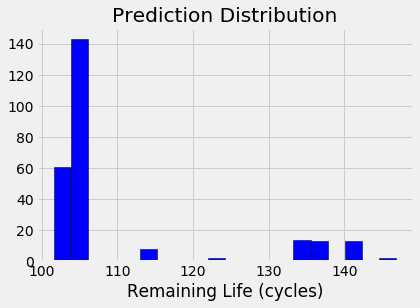

In [21]:
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

plt.hist(preds, bins = 20, color = 'blue', edgecolor = 'k')
plt.title('Prediction Distribution'); plt.xlabel('Remaining Life (cycles)');

We can also plot the 10 most important features to see what the model thinks are the most relevant features we made.

,feature,importance,importance_normalized,cumulative_importance
0,operational_setting_2-sum,0.214550,0.214550,0.214550
1,operational_setting_1-sum,0.090473,0.090473,0.305023
2,sensor_measurement_4-max,0.079222,0.079222,0.384245
3,sensor_measurement_16-sum,0.042174,0.042174,0.426419
4,sensor_measurement_15-sum,0.041890,0.041890,0.468308
5,sensor_measurement_12-sum,0.032634,0.032634,0.500942
6,sensor_measurement_11-max,0.031334,0.031334,0.532275
7,sensor_measurement_8-max,0.029826,0.029826,0.562102
8,sensor_measurement_15-max,0.021419,0.021419,0.583521
9,sensor_measurement_3-max,0.018774,0.018774,0.602295


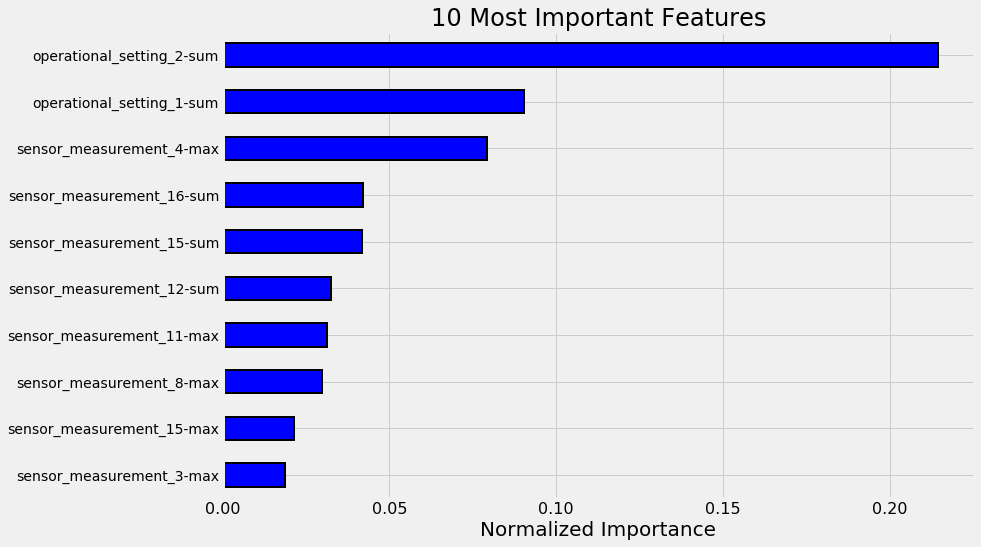

In [22]:
norm_fi = plot_feature_importances(fi, 10)
norm_fi.head(10)

It seems the model was not able to learn, predicting nearly the same value for all engines. One possible issue is the presence of too many irrelevant features.

## Feature Selection

Feature selection is nearly as important as feature engineering because irrelevant features can slow down model training, lead to poorer performance on the test set, and result in less model interpretability. Below, we apply four methods of feature selection (see the `utils.py` file and the `feature_selection` function for details) to the dataset and then re-evaluate. Feature selection here is composed of:

1. Remove columns with more than 90% missing values
2. Remove columns with only a single unique value
3. Remove one of each pair of columns with a correlation greater than 0.95.

Removing some of the features can help the model generalize to the testing data.

In [23]:
train_fs = feature_selection(train)
test_fs = test[train_fs.columns]

Original shape:  (260, 150)
20 missing columns with threshold: 90.
15 zero variance columns.
72 collinear columns removed with threshold: 0.95.
Total columns removed:  107
Shape after feature selection: (260, 43).


In [24]:
preds, fi = evaluate(train_fs, train_labels, test_fs, test_labels)

5-fold CV MAPE: 46.63 with std: 5.49
Test MAPE: 51.33.


The performance increases significantly! Our model is now significantly better than the baseline in both cross validation and on the training data. This highlights the importance of proper feature selection. 

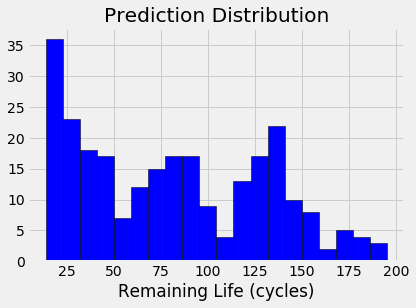

In [25]:
plt.hist(preds, bins = 20, color = 'blue', edgecolor = 'k')
plt.title('Prediction Distribution'); plt.xlabel('Remaining Life (cycles)');

,feature,importance,importance_normalized,cumulative_importance
0,operational_setting_1-sum,0.402817,0.402817,0.402817
1,time_in_cycles-sum,0.162060,0.162060,0.564877
2,sensor_measurement_11-max,0.095726,0.095726,0.660603
3,sensor_measurement_15-max,0.058629,0.058629,0.719232
4,sensor_measurement_13-max,0.021799,0.021799,0.741031


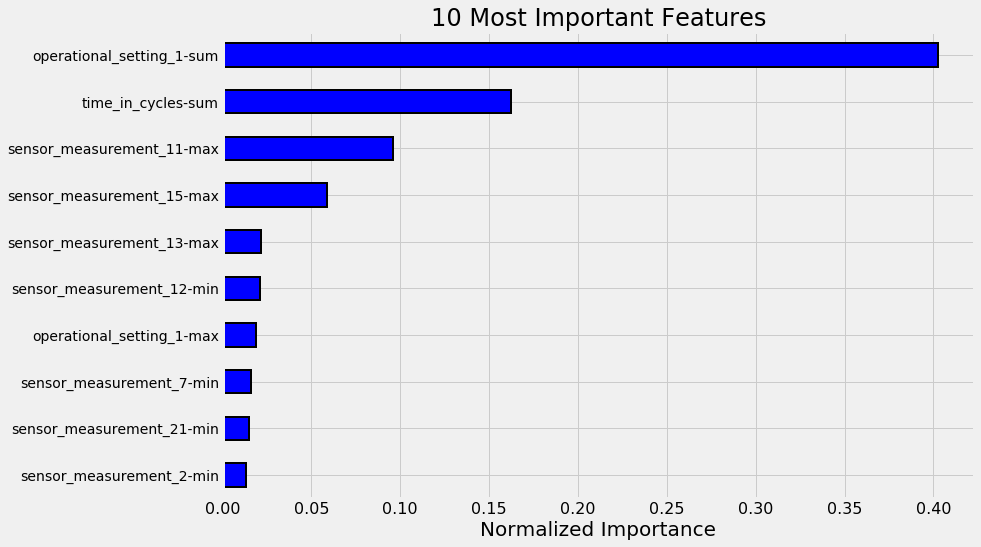

In [26]:
norm_fi = plot_feature_importances(fi, 10)
norm_fi.head()

The most important features now make more sense: _the total previous cycles of the engine is the second greatest predictor of how much longer the engine will last_. We also can see that the first operational setting is important as well as sensors 11 and 15. These can give us clues as to what to focus on when monitoring future engines.

__Through feature selection, we went from a model that was no better than a naive guess, to a model that reduced the error of the guess by more than 75%!__

In [27]:
train_fs.head()

,operational_setting_1-min,operational_setting_1-max,operational_setting_1-mean,operational_setting_1-sum,operational_setting_1-std,operational_setting_2-max,operational_setting_2-mean,operational_setting_2-std,operational_setting_3-mean,sensor_measurement_1-std,...,sensor_measurement_2-std,sensor_measurement_20-min,sensor_measurement_21-min,sensor_measurement_3-min,sensor_measurement_4-min,sensor_measurement_6-min,sensor_measurement_7-min,sensor_measurement_9-min,sensor_measurement_9-max,time_in_cycles-sum
0,0.0000,42.0077,25.414484,3024.3236,15.300117,0.8419,0.590210,0.315502,93.277311,27.467065,...,38.696380,10.36,6.2655,1256.76,1040.99,5.71,137.57,7993.23,9051.13,7140
1,0.0000,42.0076,23.734917,3370.3582,14.711035,0.8420,0.571921,0.310070,93.239437,26.707534,...,38.276363,10.37,6.2350,1253.86,1041.62,5.71,138.15,8005.94,9074.03,10153
2,0.0002,42.0073,25.365650,2029.2520,13.972098,0.8420,0.600951,0.282966,94.500000,23.920742,...,33.686785,10.41,6.2373,1255.74,1035.67,5.71,137.85,8007.77,9060.51,3240
3,0.0004,42.0075,23.640294,1891.2235,15.508015,0.8415,0.563961,0.323623,96.000000,27.701499,...,37.826324,10.44,6.2519,1257.79,1043.12,5.71,138.09,8004.46,9061.68,3240
4,0.0008,42.0071,21.721191,695.0781,14.481060,0.8417,0.528438,0.319769,93.750000,26.122518,...,37.739928,10.48,6.3157,1255.29,1037.43,5.71,138.32,8009.47,9066.37,528


In [28]:
train_fs['time_in_cycles-max'] = list(train_agg['time_in_cycles-max'])
train_fs.to_csv('../input/simple_manual_features.csv')

## More Advanced Feature Engineering

To try and build a better model, we can apply more advanced feature engineering techniques. Since our data is in a time-series, we can apply any time-series operation to each engine. For example, we can find the percentage change and the cumulative sum for each engine.

In [29]:
train_obs = train_obs.sort_values(['engine_no', 'time_in_cycles'])
train_obs.head()

,engine_no,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_10,sensor_measurement_11,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,...,sensor_measurement_25,sensor_measurement_26,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,sensor_measurement_6,sensor_measurement_7,sensor_measurement_8,sensor_measurement_9,time_in_cycles
0,1,34.9983,0.8400,100.0,449.44,1.02,42.02,183.06,2387.72,8048.56,...,NaN,NaN,1358.61,1137.23,5.48,8.00,194.64,2222.65,8341.91,1
1,1,41.9982,0.8408,100.0,445.00,1.02,42.20,130.42,2387.66,8072.30,...,NaN,NaN,1353.22,1125.78,3.91,5.71,138.51,2211.57,8303.96,2
2,1,24.9988,0.6218,60.0,462.54,0.94,36.69,164.22,2028.03,7864.87,...,NaN,NaN,1256.76,1047.45,7.05,9.02,175.71,1915.11,8001.42,3
3,1,42.0077,0.8416,100.0,445.00,1.02,41.96,130.72,2387.61,8068.66,...,NaN,NaN,1354.03,1126.38,3.91,5.71,138.46,2211.58,8303.96,4
4,1,25.0005,0.6203,60.0,462.54,0.94,36.89,164.31,2028.00,7861.23,...,NaN,NaN,1257.71,1047.93,7.05,9.03,175.05,1915.10,7993.23,5


In [30]:
train_exp = train_obs.copy()

# Find percentage change and cumulative sum for each engine
for col in train_obs:
    train_exp[f'{col}_pct_change'] = train_obs.groupby('engine_no')[col].apply(lambda x: x.pct_change())
    train_exp[f'{col}_cum_sum'] = train_obs.groupby('engine_no')[col].apply(lambda x: np.cumsum(x))
    
train_exp.head()

,engine_no,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_10,sensor_measurement_11,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,...,sensor_measurement_6_pct_change,sensor_measurement_6_cum_sum,sensor_measurement_7_pct_change,sensor_measurement_7_cum_sum,sensor_measurement_8_pct_change,sensor_measurement_8_cum_sum,sensor_measurement_9_pct_change,sensor_measurement_9_cum_sum,time_in_cycles_pct_change,time_in_cycles_cum_sum
0,1,34.9983,0.8400,100.0,449.44,1.02,42.02,183.06,2387.72,8048.56,...,NaN,8.00,NaN,194.64,NaN,2222.65,NaN,8341.91,NaN,1
1,1,41.9982,0.8408,100.0,445.00,1.02,42.20,130.42,2387.66,8072.30,...,-0.286250,13.71,-0.288379,333.15,-0.004985,4434.22,-0.004549,16645.87,1.000000,3
2,1,24.9988,0.6218,60.0,462.54,0.94,36.69,164.22,2028.03,7864.87,...,0.579685,22.73,0.268573,508.86,-0.134050,6349.33,-0.036433,24647.29,0.500000,6
3,1,42.0077,0.8416,100.0,445.00,1.02,41.96,130.72,2387.61,8068.66,...,-0.366962,28.44,-0.211997,647.32,0.154806,8560.91,0.037811,32951.25,0.333333,10
4,1,25.0005,0.6203,60.0,462.54,0.94,36.89,164.31,2028.00,7861.23,...,0.581436,37.47,0.264264,822.37,-0.134058,10476.01,-0.037419,40944.48,0.250000,15


Since this just created new columns of observations, we can take this data and aggregate it to get a single dataframe for testing with one row for each engine. The function below carries out the aggregations and renaming of columns.

In [31]:
def agg_and_rename(df, agg_variable):
    """Function to aggregate a dataframe"""
    
    df_agg = df.groupby(agg_variable).agg(['min', 'max', 'mean', 'sum', 'std'])

    new_cols = []

    # Create a rename set of columns
    for col in df_agg.columns.levels[0]:
        for stat in df_agg.columns.levels[1]:
            new_cols.append(f'{col}-{stat}')

    df_agg.columns = new_cols
    
    return df_agg

In [32]:
train_exp_agg = agg_and_rename(train_exp, 'engine_no')
train_exp_agg.head()

,operational_setting_1-min,operational_setting_1-max,operational_setting_1-mean,operational_setting_1-sum,operational_setting_1-std,operational_setting_2-min,operational_setting_2-max,operational_setting_2-mean,operational_setting_2-sum,operational_setting_2-std,...,time_in_cycles_pct_change-min,time_in_cycles_pct_change-max,time_in_cycles_pct_change-mean,time_in_cycles_pct_change-sum,time_in_cycles_pct_change-std,time_in_cycles_cum_sum-min,time_in_cycles_cum_sum-max,time_in_cycles_cum_sum-mean,time_in_cycles_cum_sum-sum,time_in_cycles_cum_sum-std
engine_no,,,,,,,,,,,,,,,,,,,,,
1,0.0000,42.0077,25.414484,3024.3236,15.300117,0.0,0.8419,0.590210,70.2350,0.315502,...,0.008475,1.0,0.045357,5.352132,0.109143,1,7140,2420.0,287980,2153.248244
2,0.0000,42.0076,23.734917,3370.3582,14.711035,0.0,0.8420,0.571921,81.2128,0.310070,...,0.007092,1.0,0.039216,5.529517,0.100748,1,10153,3432.0,487344,3056.265695
3,0.0002,42.0073,25.365650,2029.2520,13.972098,0.0,0.8420,0.600951,48.0761,0.282966,...,0.012658,1.0,0.062696,4.952979,0.130179,1,3240,1107.0,88560,982.498855
4,0.0004,42.0075,23.640294,1891.2235,15.508015,0.0,0.8415,0.563961,45.1169,0.323623,...,0.012658,1.0,0.062696,4.952979,0.130179,1,3240,1107.0,88560,982.498855
5,0.0008,42.0071,21.721191,695.0781,14.481060,0.0,0.8417,0.528438,16.9100,0.319769,...,0.032258,1.0,0.129911,4.027245,0.190614,1,528,187.0,5984,164.097532


Now we apply the same operation to the testing data, do feature selection on the training data, subset the testing data to the same columns as the training data, and evaluate!

In [33]:
test_obs.drop(columns = 'time', inplace = True)
test_exp = test_obs.copy()

# Apply operations to testing data
for col in test_obs:
    test_exp[f'{col}_pct_change'] = test_obs.groupby('engine_no')[col].apply(lambda x: x.pct_change())
    test_exp[f'{col}_cum_sum'] = test_obs.groupby('engine_no')[col].apply(lambda x: np.cumsum(x))

test_exp_agg = agg_and_rename(test_exp, 'engine_no')

In [34]:
# Feature selection and subsetting of test data
train_exp_agg_fs = feature_selection(train_exp_agg, 90, 0.95)
test_exp_agg_fs = test_exp_agg[train_exp_agg_fs.columns]

Original shape:  (260, 455)
61 missing columns with threshold: 90.
34 zero variance columns.
267 collinear columns removed with threshold: 0.95.
Total columns removed:  362
Shape after feature selection: (260, 93).


In [35]:
preds, fi = evaluate(train_exp_agg_fs, train_labels, test_exp_agg_fs, test_labels)

5-fold CV MAPE: 45.84 with std: 4.36
Test MAPE: 54.12.


It appears we may have reached the limits of what we can do with feature engineering given that we added more features and yet the performance did not increase. It's possible we are approaching [Bayes error](https://en.wikipedia.org/wiki/Bayes_error_rate), which is the lowest possible error its possible to get on a problem. This is a function of noise in the data and latent (hidden) variables that we cannot measure. The problem with Bayes error is we can never know when we have reached that point, because it would require a model that we know for sure achieves that error rate.

,feature,importance,importance_normalized,cumulative_importance
0,operational_setting_1-sum,0.376995,0.376995,0.376995
1,sensor_measurement_11-max,0.084983,0.084983,0.461978
2,time_in_cycles_pct_change-min,0.047509,0.047509,0.509487
3,time_in_cycles_pct_change-sum,0.046002,0.046002,0.555489
4,sensor_measurement_15-max,0.044009,0.044009,0.599498


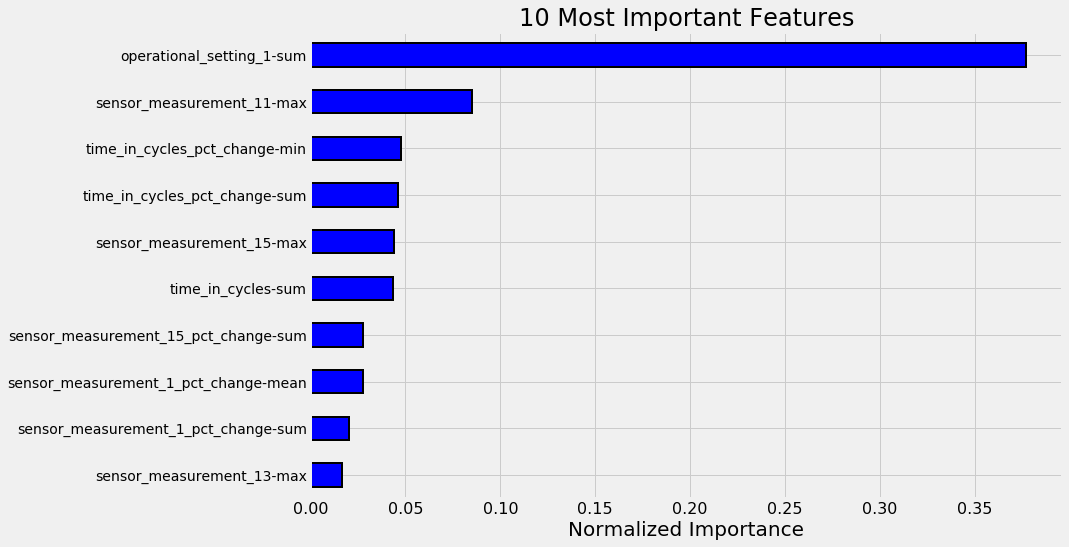

In [36]:
norm_fi = plot_feature_importances(fi, 10)
norm_fi.head()

The model has about the same performance even with the added features. We can see some of the percentage change features we added as among the most important features. 

## KMeans clustering and Time-Series Analysis

We can try one more manual feature engineering effort using clustering and time-series analysis methods. This time, we will not use the `pct_change` and `cum_sum` because these features did not improve the model. The basic outline is:

* Clustering: First we will cluster the observations into 10 unique clusters. We can then perform numerical aggregations on these clusters to get the information into our training dataframe. 
* Time-series analysis: Using the `tsfresh` package, we can apply a number of functions such as `number_peaks` and `cid_ce`. 

In [37]:
from sklearn.cluster import KMeans

In [38]:
kmeans = KMeans(n_clusters = 10)

# Need to impute the missing values
imputer = Imputer(strategy='median')
train_cluster = imputer.fit_transform(train_obs.drop(columns = ['engine_no', 'time_in_cycles']))

# Create a new column with the cluster label
train_obs['cluster'] = kmeans.fit_predict(train_cluster)

Next we apply the same procedure to the testing data (but just `transform` since we can only `fit` to training data).

The new column contains the cluster assigned to each observation. This will still require aggregating since it is on a per-observation level instead of for each engine.

In [39]:
test_cluster = imputer.transform(test_obs.drop(columns = ['engine_no', 'time_in_cycles']))
test_obs['cluster'] = kmeans.predict(test_cluster)

### Visualize Clusters
 
We can try to visualize the clusters by applying a [UMAP embedding](https://github.com/lmcinnes/umap) to the data. This reduces the dimension of data primarily for visualization.

In [40]:
import umap

reducer = umap.UMAP(n_components = 3)
train_embedding = reducer.fit_transform(train_cluster)

/anaconda3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding 6 connected components using meta-embedding (experimental)
  n_components


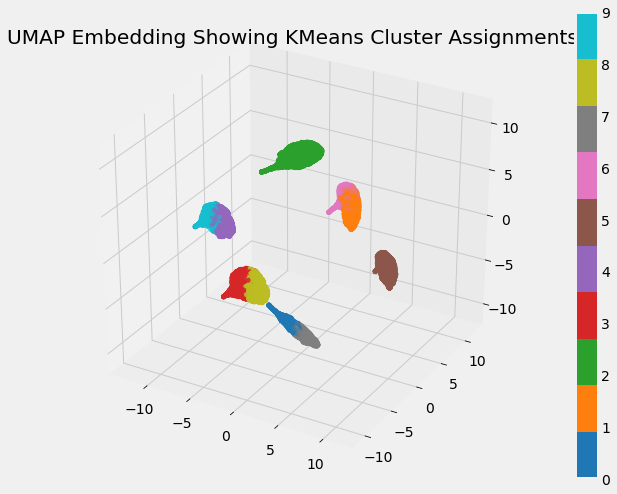

In [41]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot(111, projection='3d')

cmap = plt.get_cmap('tab10', 10)
p = ax.scatter(train_embedding[:, 0], train_embedding[:, 1], train_embedding[:, 2], 
               c = train_obs['cluster'], cmap = cmap)
plt.title('UMAP Embedding Showing KMeans Cluster Assignments')
fig.colorbar(p);

The UMAP embedding shows the clusters pretty clearly separate the observations, so perhaps they can be useful. Through clustering, we're hoping that observations that have the same cluster encode similar information which can then be used to predict how much longer an engine will run. 

To get one observation per engine, we again have to aggregate by the `engine_no`. This time we will have five extra columns with the aggregations of the cluster assignments. 

In [42]:
train_agg = agg_and_rename(train_obs, 'engine_no')
train_agg.head()

,operational_setting_1-min,operational_setting_1-max,operational_setting_1-mean,operational_setting_1-sum,operational_setting_1-std,operational_setting_2-min,operational_setting_2-max,operational_setting_2-mean,operational_setting_2-sum,operational_setting_2-std,...,time_in_cycles-min,time_in_cycles-max,time_in_cycles-mean,time_in_cycles-sum,time_in_cycles-std,cluster-min,cluster-max,cluster-mean,cluster-sum,cluster-std
engine_no,,,,,,,,,,,,,,,,,,,,,
1,0.0000,42.0077,25.414484,3024.3236,15.300117,0.0,0.8419,0.590210,70.2350,0.315502,...,1,119,60.0,7140,34.496377,1,8,3.815126,454,2.674317
2,0.0000,42.0076,23.734917,3370.3582,14.711035,0.0,0.8420,0.571921,81.2128,0.310070,...,1,142,71.5,10153,41.135953,0,9,4.429577,629,2.869250
3,0.0002,42.0073,25.365650,2029.2520,13.972098,0.0,0.8420,0.600951,48.0761,0.282966,...,1,80,40.5,3240,23.237900,0,9,3.725000,298,2.728077
4,0.0004,42.0075,23.640294,1891.2235,15.508015,0.0,0.8415,0.563961,45.1169,0.323623,...,1,80,40.5,3240,23.237900,0,9,3.850000,308,2.942917
5,0.0008,42.0071,21.721191,695.0781,14.481060,0.0,0.8417,0.528438,16.9100,0.319769,...,1,32,16.5,528,9.380832,0,9,3.312500,106,2.740820


In [43]:
test_agg = agg_and_rename(test_obs, 'engine_no')

### Time Series Operations using tsfresh

For the time series operations, we have any number of choices we can make from `tsfresh`. Each of these operations is applied to a single time-series and generates one number. Therefore, to apply them, we group by the the `engine_no` and then apply the operation to get a single observation per engine. We will choose five different operations:

1. `cid_ce`: measures the complexity of a time series
2. `number_peaks`: measures the number of peaks where a peak is bigger than `n` neighbors to the right and left
3. `last_location_of_maximum`: locates the last occurrence of the maximum value in the time series
4. `skewness`: the Fisher-Pearson skewness of the time series
5. `sample_entropy`: the sample entropy of the time series

All of these will be calculated for each operational setting and each sensor measurement giving us 5 new columns for each of the 29 original features (145 total features).

In [44]:
from tsfresh.feature_extraction.feature_calculators import (cid_ce, number_peaks, 
                                                             last_location_of_maximum, 
                                                             skewness, sample_entropy)

To avoid the issue of passing multiple functions to `agg` with the same name `lambda`, we have to create lambda functions and then give them custom names. `cid_ce` and `number_peaks` both have required arguments but the other functions only need a time-series.

In [45]:
cid_ce_func = lambda x: cid_ce(x, normalize=False)
cid_ce_func.__name__ = 'cid_ce'

n_peaks = lambda x: number_peaks(x, n = 5)
n_peaks.__name__ = 'number_peaks'

# Apply the five operations
ts_values = train_obs.drop(columns = ['time_in_cycles']).groupby('engine_no').agg([cid_ce_func, n_peaks, 
                                                                                   last_location_of_maximum,
                                                                                   skewness, sample_entropy])
ts_values.head()

/anaconda3/lib/python3.6/site-packages/tsfresh/feature_extraction/feature_calculators.py:1004: RuntimeWarning: invalid value encountered in greater
  result_first = (x_reduced > np.roll(x, i)[n:-n])
/anaconda3/lib/python3.6/site-packages/tsfresh/feature_extraction/feature_calculators.py:1011: RuntimeWarning: invalid value encountered in greater
  res &= (x_reduced > np.roll(x, -i)[n:-n])
/anaconda3/lib/python3.6/site-packages/tsfresh/feature_extraction/feature_calculators.py:1422: RuntimeWarning: invalid value encountered in true_divide
  similarity_ratio = A / B
/anaconda3/lib/python3.6/site-packages/tsfresh/feature_extraction/feature_calculators.py:1423: RuntimeWarning: divide by zero encountered in log
  se = -1 * np.log(similarity_ratio)


operational_setting_1                                        \
                         cid_ce number_peaks last_location_of_maximum   
engine_no                                                               
1                    222.130414          7.0                 0.033613   
2                    249.163933         13.0                 0.464789   
3                    187.684211          7.0                 0.637500   
4                    187.265336          5.0                 0.875000   
5                    126.381589          2.0                 0.218750   

                                   operational_setting_2               \
           skewness sample_entropy                cid_ce number_peaks   
engine_no                                                               
1         -0.452181       1.666739              4.527149         10.0   
2         -0.256690       1.765438              5.263269         10.0   
3         -0.234855       1.714447              3.936826          7.0   
4         -0.201569       1.716206              3.947116          5.0   
5         -0.074413       1.929910              2.829646          2.0   

                                                                 ...        \
          last_location_of_maximum  skewness sample_entropy      ...         
engine_no                                                        ...         
1                         0.915966 -1.009877       1.297623      ...         
2                         0.584507 -0.910519       1.452252      ...         
3                         0.712500 -0.887928       1.333294      ...         
4                         0.225000 -0.815704       1.405464      ...         
5                         0.906250 -0.555121       1.581603      ...         

          sensor_measurement_9                                        \
                        cid_ce number_peaks last_location_of_maximum   
engine_no                                                              
1                  4830.565873          8.0                  0.94958   
2                  5441.308244          9.0                  0.56338   
3                  4019.268267          6.0                  0.82500   
4                  4059.046791          7.0                  0.12500   
5                  3108.209486          2.0                  0.71875   

                                      cluster               \
           skewness sample_entropy     cid_ce number_peaks   
engine_no                                                    
1          0.353665       1.215096  38.223030            2   
2          0.112458       1.285921  49.839743            5   
3          0.076565       1.161633  33.301652            5   
4          0.052436       1.227453  35.355339            7   
5         -0.053732       1.354546  21.189620            1   

                                                             
          last_location_of_maximum  skewness sample_entropy  
engine_no                                                    
1                         0.949580  0.406855       1.666739  
2                         0.985915  0.171693       1.850700  
3                         0.975000  0.266468       2.118156  
4                         1.000000  0.300610       2.163924  
5                         0.750000  0.582748       2.063441  

[5 rows x 150 columns]

Below we rename the columns.

In [46]:
new_cols = []

# Iterate through columns
for col in ts_values.columns.levels[0]:
    for stat in ts_values.columns.levels[1]:
        new_cols.append(f'{col}-{stat}')

In [47]:
ts_values.columns = new_cols

This dataframe can then be joined to the training data because there is one observation for each engine.

In [48]:
train_obs['engine_no'] = train_obs['engine_no'].astype(np.int32)

In [49]:
train_agg = train_agg.merge(ts_values, on = 'engine_no', how = 'outer')
train_agg.head()

,operational_setting_1-min,operational_setting_1-max,operational_setting_1-mean,operational_setting_1-sum,operational_setting_1-std,operational_setting_2-min,operational_setting_2-max,operational_setting_2-mean,operational_setting_2-sum,operational_setting_2-std,...,sensor_measurement_9-cid_ce,sensor_measurement_9-number_peaks,sensor_measurement_9-last_location_of_maximum,sensor_measurement_9-skewness,sensor_measurement_9-sample_entropy,cluster-cid_ce,cluster-number_peaks,cluster-last_location_of_maximum,cluster-skewness,cluster-sample_entropy
engine_no,,,,,,,,,,,,,,,,,,,,,
1,0.0000,42.0077,25.414484,3024.3236,15.300117,0.0,0.8419,0.590210,70.2350,0.315502,...,4830.565873,8.0,0.94958,0.353665,1.215096,38.223030,2,0.949580,0.406855,1.666739
2,0.0000,42.0076,23.734917,3370.3582,14.711035,0.0,0.8420,0.571921,81.2128,0.310070,...,5441.308244,9.0,0.56338,0.112458,1.285921,49.839743,5,0.985915,0.171693,1.850700
3,0.0002,42.0073,25.365650,2029.2520,13.972098,0.0,0.8420,0.600951,48.0761,0.282966,...,4019.268267,6.0,0.82500,0.076565,1.161633,33.301652,5,0.975000,0.266468,2.118156
4,0.0004,42.0075,23.640294,1891.2235,15.508015,0.0,0.8415,0.563961,45.1169,0.323623,...,4059.046791,7.0,0.12500,0.052436,1.227453,35.355339,7,1.000000,0.300610,2.163924
5,0.0008,42.0071,21.721191,695.0781,14.481060,0.0,0.8417,0.528438,16.9100,0.319769,...,3108.209486,2.0,0.71875,-0.053732,1.354546,21.189620,1,0.750000,0.582748,2.063441


We're up to 305 features (before feature selection). Now, we apply the same operations to the testing data.

In [50]:
# Apply the five operations
ts_values_test = test_obs.drop(columns = ['time_in_cycles']).groupby('engine_no').agg([cid_ce_func, n_peaks, 
                                                                                   last_location_of_maximum,
                                                                                   skewness, sample_entropy])

# Rename the columns
new_cols = []

for col in ts_values_test.columns.levels[0]:
    for stat in ts_values_test.columns.levels[1]:
        new_cols.append(f'{col}-{stat}')
        
        
ts_values_test.columns = new_cols

/anaconda3/lib/python3.6/site-packages/tsfresh/feature_extraction/feature_calculators.py:1004: RuntimeWarning: invalid value encountered in greater
  result_first = (x_reduced > np.roll(x, i)[n:-n])
/anaconda3/lib/python3.6/site-packages/tsfresh/feature_extraction/feature_calculators.py:1011: RuntimeWarning: invalid value encountered in greater
  res &= (x_reduced > np.roll(x, -i)[n:-n])
/anaconda3/lib/python3.6/site-packages/tsfresh/feature_extraction/feature_calculators.py:1422: RuntimeWarning: invalid value encountered in true_divide
  similarity_ratio = A / B
/anaconda3/lib/python3.6/site-packages/tsfresh/feature_extraction/feature_calculators.py:1423: RuntimeWarning: divide by zero encountered in log
  se = -1 * np.log(similarity_ratio)


In [51]:
test_agg = test_agg.merge(ts_values_test, on = 'engine_no', how = 'outer')

Finally, we can apply feature selection and then evalute the new set of features.

In [52]:
train_agg_fs = feature_selection(train_agg, 90, 0.95)
final_features = list(train_agg_fs.columns)
test_agg_fs = test_agg[train_agg_fs.columns]

Original shape:  (260, 305)
30 missing columns with threshold: 90.
32 zero variance columns.
153 collinear columns removed with threshold: 0.95.
Total columns removed:  215
Shape after feature selection: (260, 90).


In [53]:
preds = evaluate(train_agg_fs, train_labels, test_agg_fs, test_labels)

5-fold CV MAPE: 44.79 with std: 5.19
Test MAPE: 52.89.


Again, we see that these features do not outperform the simple aggregations on the testing data. This might show that the new features are not helping the model.

## Random Search

The model we used to evaluate the features was an unoptimized random forest. In order to make sure we are getting the most out of the model, we should perform random search over the hyperparameters. To do this, we can use [`RandomizedSearchCV` from Scikit-Learn](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html). The process is as follows:

1. Select a metric: we already made a scorer using MAPE
2. Define a hyperparameter grid over the search domain for the following hyperparameters:
    * `n_estimators`
    * `max_depth`
    * `min_samples_leaf`
    * `max_features`
3. Run random search for 100 iterations
4. Extract the best hyperparameters and use these for the final model

__We will only use the random search on the final set of features because these had the best performance in cross validation.__

In [54]:
from sklearn.model_selection import RandomizedSearchCV

scorer = mape_scorer

# Hyperparameter grid
param_grid = {
    'n_estimators': [int(x) for x in np.linspace(50, 1000, num = 100)],
    'max_depth': [None] + [int(x) for x in np.linspace(4, 20)],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': ['auto', 'sqrt', 0.5, 'log2', None]
}

In [55]:
# Make a model 
reg = RandomForestRegressor(n_jobs = -1, random_state = 50)

# RandomizedSearchCV object
random = RandomizedSearchCV(reg, param_grid, n_iter = 100, scoring = scorer, 
                            verbose = 1, n_jobs = -1, cv = 5, random_state = 50)

# Fit on the training data
random.fit(train_agg_fs, train_labels)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.2min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=50, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [50, 59, 69, 78, 88, 97, 107, 117, 126, 136, 145, 155, 165, 174, 184, 193, 203, 213, 222, 232, 241, 251, 261, 270, 280, 289, 299, 309, 318, 328, 337, 347, 357, 366, 376, 385, 395, 405, 414, 424, 433, 443, 453, 462, 472, 481, 491, 501, 510, 520, 529, 539, 548, 558...19, 19, 20], 'min_samples_leaf': [1, 2, 5, 10], 'max_features': ['auto', 'sqrt', 0.5, 'log2', None]},
          pre_dispatch='2*n_jobs', random_state=50, refit=True,
          re

In [56]:
random.best_params_

{'n_estimators': 88,
 'min_samples_leaf': 5,
 'max_features': 'auto',
 'max_depth': 18}

### Evaluate Best Model

We'll use the set of feature from aggregations, kmeans clustering, and time-series analysis along with the optimal hyperparameters to train one final model. Through random search with cross validation, we are making the assumption that the hyperparameters that do the best in cross validation will translate to doing well on the testing data. 

In [57]:
best_score = -1 * random.best_score_
best_score_std = random.cv_results_['std_test_score'][np.argmax(random.cv_results_['mean_test_score'])]
best_model = random.best_estimator_

# Need to impute the values on the test data
imputer.fit(train_agg_fs)
test_agg_fs = test_agg_fs.replace({np.inf: np.nan})
test_agg_fs = imputer.transform(test_agg_fs) 

In [58]:
# Make predictions on the. test data
preds = best_model.predict(test_agg_fs)
final_mape = mape(test_labels, preds)

print('5-fold Cross Validation MAPE: {:.2f} with std: {:.2f}'.format(best_score, best_score_std))
print('Test MAPE: {:.2f}.'.format(final_mape))

5-fold Cross Validation MAPE: 44.75 with std: 4.73
Test MAPE: 48.62.


The 5-fold cross validation MAPE stayed about the same, but the Test MAPE has slightly decreased over the unoptimized random forest. 

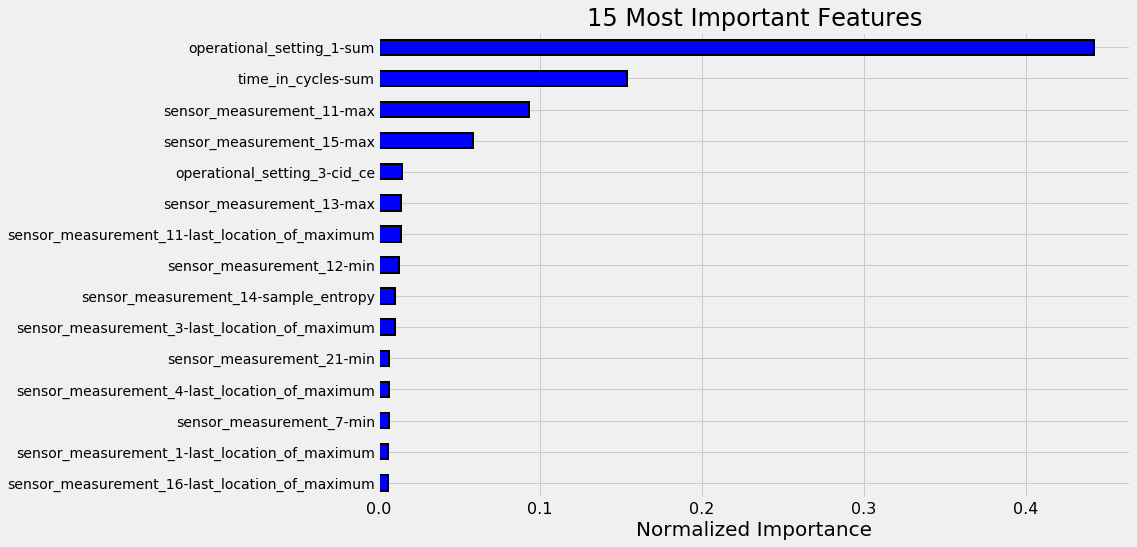

In [59]:
fi = pd.DataFrame({'feature': final_features, 'importance': best_model.feature_importances_})
norm_fi = plot_feature_importances(fi)

It does not appear that the KMeans clustering had much effect on the model because none of the top 15 most important features involve the cluster. The complexity and entropy both make it into the top features suggesting these may have a beneficial effect on the model. 

__Overall, the simple aggregations and the more complex time-series methods, along with random search to optimize the hyperparameters, yields the best model performance on the test data__.

# Conclusions 

After several rounds of manual feature engineering following are the results (the scores may have changed slightly over runs of the notebook. Even setting a random seed for the model did not result in identical performance metrics):

| Feature Set                                                      	| Model                   	| Number of Features   (before selection) 	| Number of Features   (after selection) 	| Time to Build 	| 5-fold Train CV MAPE 	| Test MAPE 	|
|------------------------------------------------------------------	|-------------------------	|-----------------------------------------	|----------------------------------------	|---------------	|----------------------	|-----------	|
| Baseline Average Train Label Guess                               	| -                       	| -                                       	| -                                      	| 15 seconds    	| 158.89 (0.00)        	| 226.44    	|
| Baseline Half Life Guess                                         	| -                       	| -                                       	| -                                      	| 30 seconds    	| 614.89 (0.00)        	| 926.51    	|
| Simple Aggregations (No Feature Selection)                       	| Default Random Forest   	| 150                                     	| 150                                    	| 120 minutes    	| 44.56 (3.22)         	| 232.47    	|
| Simple Aggregations (With Feature Selection)                      	| Default Random Forest   	| 150                                     	| 42                                     	| 120 minutes    	| 46.62 (4.46)         	| 51.48     	|
| Simple Aggregations +  Percent Change and Cumuluative Sum        	| Default Random Forest   	| 455                                     	| 88                                     	| 150 minutes   	| 46.13 (4.93)         	| 53.11     	|
| Simple Aggregations + KMeans Clustering and Time-Series Analysis 	| Default Random Forest   	| 305                                     	| 88                                     	| 180 minutes   	| 45.36 (5.35)         	| 50.33     	|
| Simple Aggregations + KMeans Clustering and Time-Series Analysis 	| Optimized Random Forest 	| 305                                     	| 88                                     	| 180 minutes   	| 45.33 (5.98)         	| 48.54     	|

The best performing model used the simple aggregations, KMeans clustering, and time-series analysis features along with the optimized random forest model. These results highlight several important takeaways:

1. Feature Engineering is critical. A simple baseline guess is very poor for this problem.
2. Feature Selection is critical. The simple aggregation set of features resulted in significant overfitting to the training set before proper feature selection was applied. 
3. Beyond a certain point, adding more complex features has diminishing returns to performance gains for this problem.
4. Model hyperparameter tuning can improve performance, but the gains are much smaller than those from feature engineering.

There were many more operations we could have applied to the data to generate features that we did not. For manual feature engineering, we are limited only by our imagination and patience. However, once we get to a certain level of performance, squeezing out every last bit of accuracy is secondary to [model interpretability](https://www.oreilly.com/learning/introduction-to-local-interpretable-model-agnostic-explanations-lime). We might want to forgo complex operations and sacrifice a minor bit of performance in order to create a more interpretable model. 

Overall, manual feature engineering was effective for this problem and resulted in a model that significantly outperforms the baseline. Nonetheless, manual feature engineering is still time-consuming, error-prone, and does not translate between problems because we have to completely re-write the code for each dataset. In the next notebook, we will implement automated feature engineering using [Featuretools](https://www.featuretools.com/), which is significantly more efficient, can be applied to any dataset with only minor changes in syntax, and will allow us to create hundreds or thousands of features which are not limited by our creavity or our time.